# **Adaptive RAG**

[Link to the paper](https://arxiv.org/abs/2403.14403)

**Architecture**:

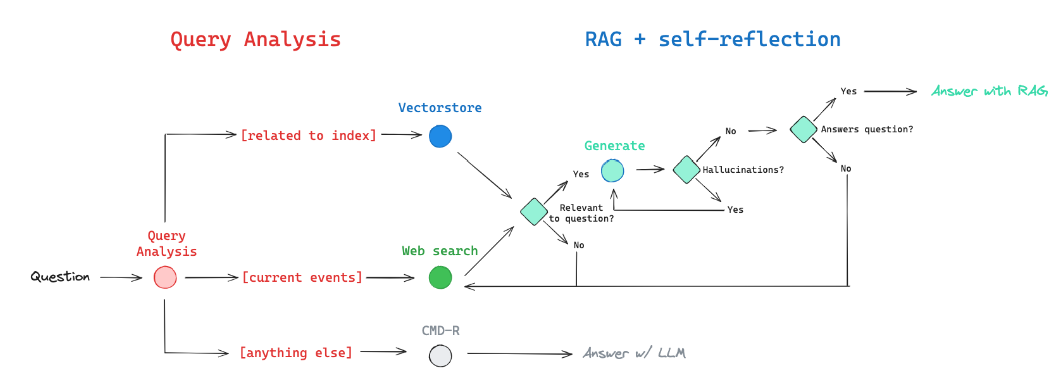

### Enhancing My Application with Adaptive RAG and Real-Time Tools



**Progress check**:
I've successfully developed an application that leverages Retrieval-Augmented Generation (RAG) techniques to interact with users and provide insights based on the information in the PDFs they upload to its database. However, I've identified limitations in the current approach, particularly the inflexibility of chains and the need for more dynamic and adaptive conversational capabilities.

**Adaptive RAG and Function-Calling**:
To overcome these limitations, I'm exploring Adaptive RAG techniques, which allow for more flexibility in building applications. By using knowledge graphs and conditional statements, I can create a more algorithmic and dynamic application that can adapt to user inputs. For instance, instead of hard-coding a specific response for a particular user input, the application can make decisions based on conditions. This adaptability enables the application to access different knowledge bases or tools based on the user's query.

**LangGraph and Tavily Search API**:
To implement Adaptive RAG techniques, I'll be using [**LangGraph**](https://python.langchain.com/v0.1/docs/langgraph/), a library from Langchain that enables the creation of knowledge graphs. LangGraph will allow me to build a more flexible and adaptive application. Additionally, I'll integrate a free public API called [**Tavily Search API**](https://python.langchain.com/v0.1/docs/integrations/retrievers/tavily/) to enhance the application's real-time conversational capabilities. While Tavily Search API may not be perfect for my use case, as it provides external knowledge, I'm interested in exploring its potential for real-time conversations.

**Expanding Functionality**:
To further enhance the application's capabilities, I'll modify my goal to include tools and function-calling. This will enable the chatbot to engage in real-time conversations with the user, answering questions such as *What day of the week is it?* or *Which club did Messi last score against?*. This expansion will not only make the application more interactive but also more useful for users.

**Expectation**:
By incorporating Adaptive RAG techniques, real-time tools, and function-calling, I aim to create a more powerful and flexible application. LangGraph will provide the foundation for building a dynamic and adaptive application, while Tavily Search API will enable real-time conversations. The ability to access different knowledge bases or tools based on user inputs will significantly enhance the application's capabilities, making it a more valuable and engaging tool for users.

Before I begin, I will load environment keys:

In [59]:
from dotenv import load_dotenv
load_dotenv()

True

I will observe queries and responses using Langchain's observability tool: [**Langsmith**](https://docs.smith.langchain.com/old). Make sure your LANGCHAIN_API_KEY has been sent to the environment.

In [60]:
import os
from uuid import uuid4


unique_id = uuid4().hex[0:8]

os.environ["LANGCHAIN_TRACING_V2"] = "true"
print("-"*40)
os.environ["LANGCHAIN_PROJECT"] = f"Blaq's PDF Chatbot - {unique_id}"

----------------------------------------


In [28]:
# Download PDF file
import requests

# Get PDF document
pdf_path = "human-nutrition-text.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File doesn't exist, downloading...
The file has been downloaded and saved as human-nutrition-text.pdf


My pipeline:

Let me improve upon my embeddings. I visited this online leaderboard - [**MTEB- Leaderboard**](https://huggingface.co/spaces/mteb/leaderboard), and settled for [**avsolatorio/GIST-all-MiniLM-L6-v2**](https://huggingface.co/avsolatorio/GIST-all-MiniLM-L6-v2) over all-MiniLM-L6-v2.


*avsolatorio/GIST-all-MiniLM-L6-v2* places higher than *all-MiniLM-L6-v2* in the leaderboard, and it is slightly less heavy.

In [61]:
import os
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyMuPDFLoader

# Check if there is a FAISS index locally
index_path = "faiss_index"
if os.path.exists(index_path):
    # Load the existing FAISS index
    hf = SentenceTransformerEmbeddings(model_name="avsolatorio/GIST-all-MiniLM-L6-v2")
    vectorstore = FAISS.load_local(index_path, hf, allow_dangerous_deserialization=True)
    retriever = vectorstore.as_retriever(search_kwargs={"k": 7})
else:
    # Load the document and create embeddings
    loader = PyMuPDFLoader(input(""))
    text_data = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=20,
        length_function=len,
        is_separator_regex=False
    )
    chunks = text_splitter.split_documents(text_data)
    hf = SentenceTransformerEmbeddings(model_name="avsolatorio/GIST-all-MiniLM-L6-v2")
    vectorstore = FAISS.from_documents(chunks, hf)
    retriever = vectorstore.as_retriever(search_kwargs={"k": 7})
    # Save the FAISS index locally
    vectorstore.save_local(index_path)

c:\Users\Odiaka\miniconda3\envs\alexey\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Advanced RAG

##### Defining Components

The Router:

This component will help my application decide whether to use the existing knowledgebase or to query the internet or whether to give a custom reply to answer the user's question.

Kindly refer to the LLM architecture diagram. This is Query Analysis.

In [62]:
### Router
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_cohere import ChatCohere

# Data model
class web_search(BaseModel):
    """
    The internet. Use web_search to query the internet for questions that require up-to-date information and could be on the internet
    """
    query: str = Field(description="The query to use when searching the internet.")

class vectorstore(BaseModel):
    """
    A vectorstore containing documents on human nutrition. Use the vectorstore for questions related to human nutrition.
    """
    query: str = Field(description="The query to use when searching the vectorstore.")

# Preamble
preamble = """You are an expert at routing user questions to the appropriate data source. First go through the state first and see if the current query is talking about some information in the state.
Then, Based on the provided question, please classify it into one of the following categories:

vectorstore: Questions related to human nutrition. 
classified: Questions that do not require up-to-date information and are also not based on human nutrition, such as questions about the emotional state of the chatbot, or intimate requests.
web_search: Questions that require up-to-date information and could be on the internet.

Reply with a JSON object containing a single key 'datasource'. Only reply with each classification such as 'vectorstore','classified', or 'web_search'. Please no preamble or explanation.

"""

# LLM with tool use and preamble
llm = ChatCohere(model="command-r", temperature=0)
structured_llm_router = llm.bind_tools(tools=[web_search, vectorstore], preamble=preamble)

# Prompt
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{question}"),
    ]
)

In [63]:
question_router = route_prompt | structured_llm_router
response = question_router.invoke({"question": "what are macronutrients?"}) #what are macronutrients?
print(response.response_metadata['tool_calls'])
response = question_router.invoke({"question": "How many dogs live within Surulere?"}) #What are the types of agent memory?
print(response.response_metadata['tool_calls'])
response = question_router.invoke({"question": "Hi, how are you?"}) #Hi how are you?
print('tool_calls' in response.response_metadata)

[{'id': '937167e00a0440299cd25bc70e2b14ec', 'function': {'name': 'vectorstore', 'arguments': '{"query": "macronutrients"}'}, 'type': 'function'}]
[{'id': '12b926ec884f4112af57ff2745950516', 'function': {'name': 'web_search', 'arguments': '{"query": "How many dogs live within Surulere?"}'}, 'type': 'function'}]
False


You see, **response.response_data** does not have an ID for a new 'tool_calls' (FALSE). This means it does not make use of a tool in answering the query *Hi, how are you?*

So the router works. It successfully classifies the user query into one of two tool options. And if I wanted to make that out of 3 options then I just use a logic where          

*tool call = FALSE*. 

Great! Now I will define the retrieved documents' grader.

The Relevancy Grader/Retrieval Grader:

This component will grade the relevancy of the retrieved documents to the user's question.

This is the part of the *Corrective RAG* technique.

In [64]:
### Retrieval Grader

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

# Prompt
preamble = """You are a grader assessing relevance of a retrieved document to a user question. \n
If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# LLM with function call
llm = ChatCohere(model="command-r", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments, preamble=preamble)

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [65]:
retrieval_grader = grade_prompt | structured_llm_grader
question = "What are macronutrients?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
response =  retrieval_grader.invoke({"question": question, "document": doc_txt})
print(response)

binary_score='yes'


*Yes*, the retrieved documents are relevant... at least my grader thinks so. 


I just graded the performance of my vector database as a retriever by checking the *relevancy* of the retrieved documents to any query. Just by doing this - by grading my database, I have almost completed the implementation of Corrective RAG or CRAG.  All there is left to it is a *conditional edge* which will have the logic to decide if my application should search another knowledgebase that may have knowledge relating to the query, or maybe re-write my query, etc; for poor grade, or just go ahead to generate the reply; for good grade. 

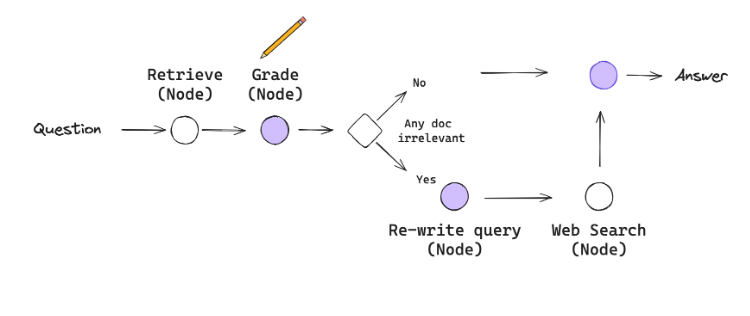

You will get to understand better when I am designing my graph. Okay, next, the re-writer.

The Query Re-writer:

This component will restructure the user query to match the semantic meaning of the knowledge base for easy retrieval.

I will be using another Cohere model for this.

In [66]:
### Re-writer

from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage
import logging


# Preamble
preamble = """You a question re-writer that converts an input question to a better version that is optimized 
     for vectorstore retrieval. Look at the initial and formulate an improved question.
     Please no preamble or extra sentences only the improved question will suffice."""

# LLM
llm = ChatCohere(model_name="command-r", temperature=0).bind(preamble=preamble)

# Prompt
rewrite_prompt = lambda x: ChatPromptTemplate.from_messages(
    [
        HumanMessage(
            f"Question: {x['question']} \nAnswer: ",
            additional_kwargs={"documents": x["documents"]},
        )
    ]
)

In [67]:
# hide warning log
logging.getLogger().setLevel(logging.ERROR)

# Chain
question_rewriter = rewrite_prompt | llm | StrOutputParser()

question = "What are macronutrients?"
docs = retriever.invoke(question)
# Run
generation = question_rewriter.invoke({"documents": docs, "question": question})
print(generation)

What are the three classes of macronutrients?


The Generator:

This component will respond to the user's question.

I will just pull a RAG prompt from HuggingFace hub.

In [68]:
question = "What are macronutrients?"

In [69]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

    # LLM
llm = ChatCohere(model="command-r", temperature=0)
# hide warning log
logging.getLogger().setLevel(logging.ERROR)
# hide warning log
logging.getLogger().setLevel(logging.ERROR)

# Chain
rag_chain = prompt | llm | StrOutputParser()
docs = retriever.invoke(question)

In [70]:
# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)
docs = retriever.invoke(question)

Macronutrients are nutrients required by the body in large amounts. They include carbohydrates, lipids, and proteins, which can be converted into cellular energy. They are also known as the “workhorses” of life.


The Substitute LLM / Fallback:

This component is a substitute generator using its pretrained knowledge to try to answer *classified* user questions.

There will be a custom reply for such questions as *Hi, how are you?*, *Do you love me?*, etc.

In [71]:
### LLM fallback

from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage


# Preamble
preamble = """You are an assistant for question-answering tasks. Answer the following question only with this reply - I'm sorry, but 🅱🅻🅰🆀 will like us to only chat about your documents. 
    Please no preamble or extra sentences just this same reply - I'm sorry, but 🅱🅻🅰🆀 will like us to only chat about your documents"""

# LLM
llm = ChatCohere(model_name="command-r", temperature=0).bind(preamble=preamble)

# Prompt
prompt2 = lambda x: ChatPromptTemplate.from_messages(
    [
        HumanMessage(
            f"Question: {x['question']} \nAnswer: "
        )
    ]
)

In [72]:
# Chain
rag_chain2 = prompt2 | llm | StrOutputParser()

# Run
question = "Hi how are you?"
generation2 = rag_chain2.invoke({"question": question})
print(generation2)

I'm sorry, but 🅱🅻🅰🆀 will like us to only chat about your documents.


Finally, I will try to complete the *Self RAG* part of Adaptive RAG architecture; which is basically everything that happens after *Generation* and the ability for the application to tackle the innate LLM challenges of hallucination. I will test for hallucinations (if, or not, the responses are from the entire knowledge base my application has access to) and also for correctness (the usefulness of the response to the query) of the generation stage, using the next 2 components.

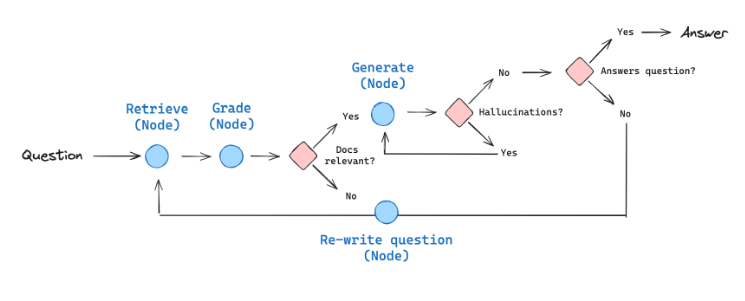


NB: Adaptive RAG is pretty customizable. However you choose to tackle the issues of relevancy and hallucinations is totally up to you and your use case. My point is do not follow what you see in the diagram literally. You will find that later I will use a Langchain feature to generate a diagram of my own architecture, and this will come after I build my graph.

The Hallucination Grader:

This component tests for hallucination in the Generator's response.

This is simply checking the LLM response against our knowledge base, which in this use case is not really necessary.

In [81]:
### Hallucination Grader

# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(description="Answer is grounded in the facts, 'yes' or 'no'")

# Preamble
preamble = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
Give a binary score 'yes' or 'no' score to indicate whether the answer is grounded in / supported by a set of facts. \n
Please provide the binary score as a JSON with a single key 'score' and no explanation."""

# LLM with function call
llm = ChatCohere(model="command-r", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations, preamble=preamble)

# Prompt
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        # ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

In [82]:
question = "What are macronutrients?"
hallucination_grader = hallucination_prompt | structured_llm_grader
docs = retriever.invoke(question)
response = hallucination_grader.invoke({"documents": docs, "generation": generation})
print(response)

binary_score='yes'


The Response Grader:

This component grades the relevance of the generator's response to the user's question.

This is simply checking the LLM response's correctness as it relates to answering the user's question.







In [83]:
### Answer Grader

# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(description="Answer addresses the question, 'yes' or 'no'")

# Preamble
preamble = """You are a grader assessing whether an answer addresses / resolves a question \n
Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question. \n
Provide the binary score as a JSON with a single key 'score' and no preamble or explanation."""

# LLM with function call
llm = ChatCohere(model="command-r", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer, preamble=preamble)

# Prompt
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

In [84]:
answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question,"generation": generation})

GradeAnswer(binary_score='yes')

All is fine and good. The components look set and ready, almost time to build my graph. 

But first, the tool.

### Web Search Tool

To gain access to this API as a tool, you need an API key. Get it [here](https://app.tavily.com/home).

In [85]:
# Uncomment and run
#! pip install -qU tavily-python

In [86]:
import getpass
import os

if "TAVILY_API_KEY" not in os.environ:
  os.environ["TAVILY_API_KEY"] = getpass.getpass("Provide your Tavily Search Api Key here: ")
  print("TAVILY_API_KEY successfully sent to the environment")

In [87]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(max_results=3)

Does this not feel like a video game and what I am now doing is selecting/choosing my characters and defining/building their abilities?

Anyway, I have my components; composed of agents and tools. I am ready to build a graph. 


A knowledge graph will have:
* Nodes (action points), 
* Edges (direction flow), and 
* State (component action update status).


Okay, Let me now implement the graph.

### Graph
Capture the Adaptive RAG architecture as a control workflow using LangGraph.

I will define the state of the graph as a class.

In [88]:
from typing import Annotated, Sequence, TypedDict, List

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class GraphState(TypedDict):
    """|
    The add_messages function defines how an update should be processed
    Default is to replace. add_messages says "append"
    
    Represents the state of my graph.

    Attributes:
        messages
    """
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [101]:
# defining the nodes (action points) and conditional edges

import pprint
from langchain_core.messages import HumanMessage, AIMessage


def route_question(state):
    """
    Route question to web search or RAG or substitute LLM.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    print("Routing query...")
    messages = state["messages"]
    question = messages[0].content
    response = question_router.invoke(question)

    # Append user query to messages list
    messages.append(HumanMessage(content=question))

    # Fallback to LLM or raise error if no decision
    if "tool_calls" not in response.additional_kwargs:
        print("Routing query to substitute generator...")
        return "llm_fallback"
    if len(response.additional_kwargs["tool_calls"]) == 0:
        raise "Router could not decide source"

    # Choose datasource
    datasource = response.additional_kwargs["tool_calls"][0]["function"]["name"]
    if datasource == 'web_search':
        print("Routing query to the web search tool...")
        return "web_search"
    elif datasource == 'vectorstore':
        print("Routing query to vector database...")
        return "vectorstore"
    else:
        print("Routing query to substitute LLM...")
        return "llm_fallback"

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("Retrieving...")
    messages = state["messages"]

    question = messages[0].content

    # Retrieval
    documents = retriever.invoke(question)
    messages_with_documents = [HumanMessage(content=doc.page_content) for doc in documents]

    # Append retrieved documents to messages list
    messages.extend(messages_with_documents)

    return {"messages": messages}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("Checking Document's relevance to query...")
    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = retrieval_grader.invoke({"document": docs , "question": question})

    score = scored_result.binary_score

    if score == "yes":
        print("GRADE: Document relevant")
        return {"messages": messages}

    else:
        print("GRADE: Document NOT relevant")
        print(score)
        return {"messages": messages}

def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("Generating response...")
    messages = state["messages"]
    question = messages[0].content
    documents = [msg.content for msg in messages[1:]]

    # Run
    response = rag_chain.invoke({"context": documents, "question": question})

    # Append generated response to messages list
    messages.append(AIMessage(content=response))
    print(f"Generation: {response}")
    return {"messages": messages}

def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("Re-writing user query...")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]
    docs = last_message.content

    question_rewriter
    response = question_rewriter.invoke({"context": docs, "question": question})

    # Append re-written question to messages list
    messages.append(HumanMessage(content=response))

    return {"messages": messages}

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("Assessing Graded documents...")
    messages = state["messages"]
    last_message = messages[-1]
    filtered_docs = last_message.content

    if not filtered_docs:
        # All documents have been filtered check_relevance
        # It will re-generate a new query
        print("DECISION: Retrieved documents are NOT relevant to query, restructuring query...")
        return "transform_query"
    else:
        # relevant documents, so generate answer
        print("DECISION: Respond.")
        return "generate"

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("searching the internet...")
    messages = state["messages"]
    question = messages[0].content

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join(d.get("content", "") for d in docs if isinstance(d, dict))
    web_results_message = HumanMessage(content=web_results)

    # Append web search results to messages list
    messages.append(web_results_message)

    return {"messages": messages}

def llm_fallback(state):
    """
    Generate answer using the LLM w/o vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("Substitute LLM.")
    messages = state["messages"]
    question = messages[0].content
    generation2 = rag_chain2.invoke({"question": question})

    # Append LLM generation to messages list
    messages.append(AIMessage(content=generation2))

    return {"messages": messages, "generation": generation2}

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("Checking for hallucination...")
    messages = state["messages"]
    question = messages[0].content
    documents = messages[-1].content

    score = hallucination_grader.invoke({"documents": documents, "generation": generation})

    # Check hallucination
    if score == "yes":
        print("DECISION: Response is grounded. No hallucination.")
        # Check question-answering
        print("Grading relevancy to user query...")
        score = answer_grader.invoke({"question": question,"generation": generation})
        if score == "yes":
            print("DECISION: Response is relevant to user query.")
            return "useful"
        else:
            print("DECISION: Response DOES NOT address user query.")
            return "not useful"
    else:
        pprint.pprint("... Loading ...")
        return "not supported"  #it's fine, that's the nature of the user query: it's unrelated to the database



Now compiling the flow chart.

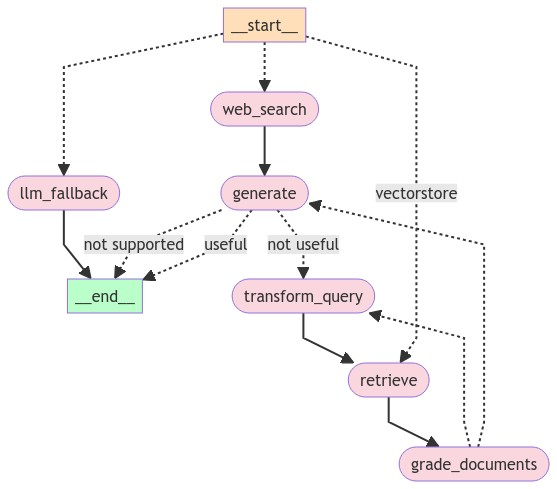

In [102]:
# The graph 

from langgraph.graph import END, StateGraph
from IPython.display import Image, display

workflow = StateGraph(GraphState)

# Adding the nodes
workflow.add_node("web_search", web_search) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # rag
workflow.add_node("llm_fallback", llm_fallback) # llm
workflow.add_node("transform_query", transform_query) #query restructure

workflow.set_conditional_entry_point(
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
        "llm_fallback": "llm_fallback",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": END, # Hallucinations: END
        "not useful": "transform_query", # Fails to answer question: fall-back to re-write query 
        "useful": END,
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_edge("llm_fallback", END)

# Compile
app = workflow.compile()
app.get_graph().draw_mermaid_png(output_file_path="graph.png")

# Display the image
display(Image(filename="graph.png"))

Like a spider web. Lol. But if you follow the logic paths carefully you can see how I tackled the issues of relevant retrieved documents, and no hallucination in generation. That sums up Adaptive RAG in a nutshell.

Great! Now, let me try it out.

In [103]:
import pprint

inputs = {
    "messages": [
        ("user", "What are macronutrients?"),
    ]
}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

Routing query...
Routing query to vector database...
Retrieving...
"Output from node 'retrieve':"
'---'
{ 'messages': [ HumanMessage(content='What are macronutrients?', id='66225270-e882-41e9-a1ef-e9f4a58587d6'),
                HumanMessage(content='Macronutrients \nNutrients \nthat \nare \nneeded \nin \nlarge \namounts \nare \ncalled \nmacronutrients. There are three classes of macronutrients: \ncarbohydrates, lipids, and proteins. These can be metabolically \nprocessed into cellular energy. The energy from macronutrients \ncomes from their chemical bonds. This chemical energy is \nconverted into cellular energy that is then utilized to perform work, \nallowing our bodies to conduct their basic functions. A unit of'),
                HumanMessage(content='macronutrient that contains nitrogen. In each amino acid the \nelements are arranged into a specific conformation around a carbon \ncenter. Each amino acid consists of a central carbon atom \nconnected to a side chain, a hydrogen, a

In [104]:
import pprint

inputs = {
    "messages": [
        ("user", "are they very important in the body?"),
    ]
}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

Routing query...
Routing query to vector database...
Retrieving...
"Output from node 'retrieve':"
'---'
{ 'messages': [ HumanMessage(content='are they very important in the body?', id='6243bcfb-0029-42a9-b6c1-d1c7efb8cf47'),
                HumanMessage(content='species, and many other free radicals. It protects lipids both by \ndisabling free radicals and by aiding in the regeneration of vitamin \nE. \nIn addition to its role as an antioxidant, vitamin C is a required \npart of several enzymes like signaling molecules in the brain, some \nhormones, and ]amino acids. Vitamin C is also essential for the \nsynthesis and maintenance of collagen. Collagen is the most \nabundant protein in the body and used for different functions such'),
                HumanMessage(content='adipose tissue secretes the hormone leptin, which regulates \nappetite. In the reproductive system, fatty acids are required for \nproper reproductive health. Women who lack proper amounts may \nstop menstruating and b

Routing seems to be working well, and the app also seems to maintain context and history.

Let me test the tools.

In [105]:
import pprint

inputs = {
    "messages": [
        ("user", "Where is Nigeria?"),
    ]
}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

Routing query...
Routing query to the web search tool...
searching the internet...
"Output from node 'web_search':"
'---'
{ 'messages': [ HumanMessage(content='Where is Nigeria?', id='a8a79ae2-ed60-49a8-adf7-5315ce404a66'),
                HumanMessage(content="The most mountainous area is along the southeastern border with Cameroon, where the Cameroon Highlands rise to the highest points in the country, Chappal Waddi (7,936 feet [2,419 metres]) in the Gotel Mountains and Mount Dimlang (6,699 feet [2,042 metres]) in the Shebshi Mountains.\n Land\nNigeria is bordered to the north by Niger, to the east by Chad and Cameroon, to the south by the Gulf of Guinea of the Atlantic Ocean, and to the west by Benin. The middle two-thirds of the country, the savanna regions, contain reddish, laterite soils; they are somewhat less fertile than those of the north because they are not subject to as much seasonal drying, nor do they receive the greater rainfall that occurs in the more southerly regions

Hmmmn. What about *guided* responses?

In [106]:
import pprint

inputs = {
    "messages": [
        ("user", "Who are you?"),
    ]
}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

Routing query...
Routing query to substitute generator...
Substitute LLM.
"Output from node 'llm_fallback':"
'---'
{ 'messages': [ HumanMessage(content='Who are you?', id='79d03075-d3d7-4bb7-afd0-5ea8ab351fab'),
                AIMessage(content="I'm sorry, but 🅱🅻🅰🆀 will like us to only chat about your documents.")]}
'\n---\n'


In [107]:
import pprint

inputs = {
    "messages": [
        ("user", "Who is Alex Pereira's next fight in the UFC?"),
    ]
}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

Routing query...
Routing query to the web search tool...
searching the internet...
"Output from node 'web_search':"
'---'
{ 'messages': [ HumanMessage(content="Who is Alex Pereira's next fight in the UFC?", id='86703110-da4e-4fc0-ba0c-6d9e0be2c653'),
                HumanMessage(content='Pereira (10-2) enters the UFC cage for the ninth time. In a short, but already accomplished run, he has won belts in two divisions, scoring dramatic wins over Prochazka and Israel Adesanya.The ...\nUFC 303 fight card, odds. Alex Pereira (c) -175 vs. Jiri Prochazka +145, light heavyweight title; Diego Lopes -150 vs. Brian Ortega +125, featherweights;\nPereira-Procházka 2 caps off another International Fight Week, which includes the UFC Hall of Fame ceremony on June 27 as well as the annual UFC X fan experience on June 28 and 29. Stay tuned to ...')]}
'\n---\n'
Generating response...
Generation: Alex Pereira's next fight will take place during UFC 303 against Jiri Prochazka. The fight has been billed as 

In [108]:
import pprint

inputs = {
    "messages": [
        ("user", "What's the use of electrolytes in the human body?"),
    ]
}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

Routing query...
Routing query to vector database...
Retrieving...
"Output from node 'retrieve':"
'---'
{ 'messages': [ HumanMessage(content="What's the use of electrolytes in the human body?", id='de883779-b139-41c9-9abe-a819916093bc'),
                HumanMessage(content='http:/\n/cebp.aacrjournals.org/content/5/7/495.long. \nAccessed September 22, 2017. \nOverview of Fluid and Electrolyte Balance  |  151'),
                HumanMessage(content='PART\xa0III \nCHAPTER 3. WATER AND \nELECTROLYTES \nChapter 3. Water and\nElectrolytes  |  143'),
                HumanMessage(content='water. Three electrolytes are more closely regulated than others: \nNa+, Ca++, and K+. The kidneys share pH regulation with the lungs \nand plasma buffers, so that proteins can preserve their three-\ndimensional conformation and thus their function. \nLearning Activities \nTechnology Note: The second edition of the Human \nNutrition Open Educational Resource (OER) textbook \nfeatures interactive learning act

### Exploring other RAG architectures

**Assessment**:
The discussions have highlighted the exceptional performance of Cohere command models for Retrieval-Augmented Generation (RAG) designs. However, the requirement for payment for API calls poses a concern for production-scale projects. Fortunately, the same implementation can be achieved using open-source models, as demonstrated in the *adaptive_rag_with_local_llm.ipynb* notebook. While the results may not match those obtained with Cohere models, they will still be decent.

**Improvement**:
From the current implementation, there is room for improvement in the control workflow. The success of the current implementation has sparked interest in the concept of agents and the REACT agent, which thinks independently and functions similarly to the router. However, the need to define the routing logic manually for each new file is not automated, which can be limiting.

**Modular Reasoning and Knowledge Learning (MRKL) REACT Agent**:
To address this limitation, I've come across a [**paper**](https://arxiv.org/abs/2205.00445) that discusses another agent architecture called the Modular Reasoning and Knowledge Learning (MRKL) REACT agent. This architecture allows for more independent and automated decision-making, eliminating the need for manual routing logic definition. I'm excited to try out this agent architecture in the final notebook, *rag_with_agent_executor.ipynb*.